In [2]:
# ==========================================================
# STEP 1: Setup and Imports
# ==========================================================
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display

print("✅ Environment initialized.")




✅ Environment initialized.


In [3]:
# ==========================================================
# STEP 2: Load Inputs
# ==========================================================
# ---- Job execution log (CSV) ----
df = pd.read_csv("jobs_log.csv")

# ---- Prerequisite map (JSON) ----
with open("job_prerequisites.json", "r") as f:
    prereq_map = {j["job_type"]: j["dependencies"] for j in json.load(f)}

print(f"✅ Loaded {len(df)} job records and {len(prereq_map)} prerequisite definitions.")


✅ Loaded 20 job records and 10 prerequisite definitions.


In [5]:
# ==========================================================
# STEP 3: Helper Functions
# ==========================================================
def normalize_status(s):
    """Normalize raw job status values."""
    s = str(s).strip().upper()
    if s == "COMPLETE": return "SUCCESS"
    if s == "PENDING": return "PENDING"
    if s.startswith("ERROR - UPDATED"): return "SYSTEM_ABORT"
    if s == "ERROR": return "ERROR"
    return "UNKNOWN"

def find_prereq_candidates(job_row, df):
    """Resolve explicit design-time prerequisites (all_of / one_of)."""
    job_type = job_row["Job_type"]
    start_time = pd.to_datetime(job_row["start_time"])
    billing_period = job_row["BillingPeriod"]

    deps = prereq_map.get(job_type, {"all_of": [], "one_of": []})
    all_of, one_of = deps.get("all_of", []), deps.get("one_of", [])
    satisfied = []

    # --- all_of ---
    for dep in all_of:
        cand = df[
            (df["Job_type"] == dep)
            & (df["BillingPeriod"] == billing_period)
            & (pd.to_datetime(df["end_time"]) < start_time)
        ]
        if cand.empty:
            return []  # missing required dependency
        latest = cand.sort_values("end_time").iloc[-1]
        satisfied.append({"dep": dep, "type": "all_of", "job": latest})

    # --- one_of ---
    if one_of:
        found = False
        for dep in one_of:
            cand = df[
                (df["Job_type"] == dep)
                & (df["BillingPeriod"] == billing_period)
                & (pd.to_datetime(df["end_time"]) < start_time)
            ]
            if not cand.empty:
                latest = cand.sort_values("end_time").iloc[-1]
                satisfied.append({"dep": dep, "type": "one_of", "job": latest})
                found = True
                break
        if not found:
            return []  # none satisfied
    return satisfied

def find_fallback_dependency(job_row, df):
    """If no design-time prereq, use most recent completed job in same period."""
    start_time = pd.to_datetime(job_row["start_time"])
    billing = job_row["BillingPeriod"]
    cand = df[
        (pd.to_datetime(df["end_time"]) < start_time)
        & (df["BillingPeriod"] == billing)
    ].sort_values("end_time")
    if cand.empty:
        return None, None
    latest = cand.iloc[-1]
    return latest["Job_type"], latest["JobId"]


In [7]:
# ==========================================================
# STEP 4: Build Nodes & Edges
# ==========================================================
edges, nodes = [], []

for _, row in df.iterrows():
    # Parse job_configs JSON safely
    try:
        job_cfgs = json.loads(row["job_configs"])
    except (json.JSONDecodeError, TypeError):
        job_cfgs = []
    posting_flag = next((c.get("postingFlag", True) for c in job_cfgs if "postingFlag" in c), True)
    node_label = f"{row['Job_type']}_Simulated" if not posting_flag else row["Job_type"]
    status_cat = normalize_status(row["status"])
    is_sim = not posting_flag

    nodes.append({
        "JobId": row["JobId"],
        "JobLabel": node_label,
        "JobType": row["Job_type"],
        "IsSimulated": is_sim,
        "StatusCat": status_cat,
        "BillingPeriod": row["BillingPeriod"],
        "StartTime": row["start_time"],
        "EndTime": row["end_time"]
    })

    prereqs = find_prereq_candidates(row, df)
    if prereqs:
        for dep in prereqs:
            edges.append({
                "SourceJob": dep["dep"],
                "TargetJob": row["Job_type"],
                "BillingPeriod": row["BillingPeriod"],
                "DependencyType": dep["type"],
                "DependencySourceId": dep["job"]["JobId"],
                "StatusCat": status_cat
            })
    else:
        src_type, src_id = find_fallback_dependency(row, df)
        if src_type:
            edges.append({
                "SourceJob": src_type,
                "TargetJob": row["Job_type"],
                "BillingPeriod": row["BillingPeriod"],
                "DependencyType": "time_inferred",
                "DependencySourceId": src_id,
                "StatusCat": status_cat
            })

print(f"✅ Extracted {len(nodes)} nodes and {len(edges)} edges.")

✅ Extracted 20 nodes and 21 edges.


In [9]:
# ==========================================================
# STEP 5: Aggregate + Export
# ==========================================================
edges_df = pd.DataFrame(edges)
nodes_df = pd.DataFrame(nodes)
edges_agg = (
    edges_df.groupby(["SourceJob","TargetJob","BillingPeriod","DependencyType","StatusCat"])
    .size().reset_index(name="Count")
)

display(edges_agg.head(8))
display(nodes_df.head(8))

edges_agg.to_csv("edges_powerbi.csv", index=False)
nodes_df.to_csv("nodes_powerbi.csv", index=False)
print("💾 Exported edges_powerbi.csv and nodes_powerbi.csv.")


,SourceJob,TargetJob,BillingPeriod,DependencyType,StatusCat,Count
0,BillingExtract,RPA_User_Upload,2025-10,time_inferred,SUCCESS,1
1,BillingExtract,RPA_User_Upload,2025-11,time_inferred,SUCCESS,1
2,BillingExtract,TPB_Simulation,2025-10,one_of,SUCCESS,1
3,BillingExtract,VB_Simulation,2025-10,one_of,SUCCESS,1
4,BillingExtract,VB_Simulation,2025-11,one_of,SUCCESS,1
5,BillingExtract,VB_Simulation,2025-11,one_of,SYSTEM_ABORT,1
6,Post_To_Zuora,Reconciliation,2025-10,all_of,SUCCESS,1
7,Post_To_Zuora,Reconciliation,2025-11,all_of,SUCCESS,1


,JobId,JobLabel,JobType,IsSimulated,StatusCat,BillingPeriod,StartTime,EndTime
0,101,BillingExtract,BillingExtract,False,SUCCESS,2025-10,2025-10-01 08:00:00,2025-10-01 08:25:00
1,102,LoadFromS3Ephemeral,LoadFromS3Ephemeral,False,SUCCESS,2025-10,2025-10-01 08:10:00,2025-10-01 08:20:00
2,103,RPA_User_Upload,RPA_User_Upload,False,SUCCESS,2025-10,2025-10-01 08:30:00,2025-10-01 08:40:00
3,104,VB_Simulation_Simulated,VB_Simulation,True,SUCCESS,2025-10,2025-10-01 08:45:00,2025-10-01 09:10:00
4,105,TPB_Simulation,TPB_Simulation,False,SUCCESS,2025-10,2025-10-01 09:15:00,2025-10-01 09:35:00
5,106,Upload_RPA,Upload_RPA,False,SUCCESS,2025-10,2025-10-01 09:40:00,2025-10-01 09:50:00
6,107,Sweep_And_Sync,Sweep_And_Sync,False,SUCCESS,2025-10,2025-10-01 09:55:00,2025-10-01 10:05:00
7,108,Zuora_Update,Zuora_Update,False,SUCCESS,2025-10,2025-10-01 09:50:00,2025-10-01 10:10:00


💾 Exported edges_powerbi.csv and nodes_powerbi.csv.


In [12]:
# ==========================================================
# STEP 6: Runtime Process Graph Visualization
# ==========================================================
G = nx.DiGraph()

In [13]:
for _, r in edges_agg.iterrows():
    color = (
        "blue" if r["DependencyType"] == "all_of"
        else "green" if r["DependencyType"] == "one_of"
        else "orange"
    )
    if r["StatusCat"] in ["ERROR","SYSTEM_ABORT"]:
        color = "red"
    style = (
        "solid" if r["DependencyType"] == "all_of"
        else "dashed" if r["DependencyType"] == "one_of"
        else "dotted"
    )
    G.add_edge(r["SourceJob"], r["TargetJob"], color=color, style=style, weight=r["Count"])

In [14]:
for _, n in nodes_df.iterrows():
    G.nodes[n["JobLabel"]] = {
        "is_sim": n["IsSimulated"],
        "status": n["StatusCat"]
    }

TypeError: 'NodeView' object does not support item assignment

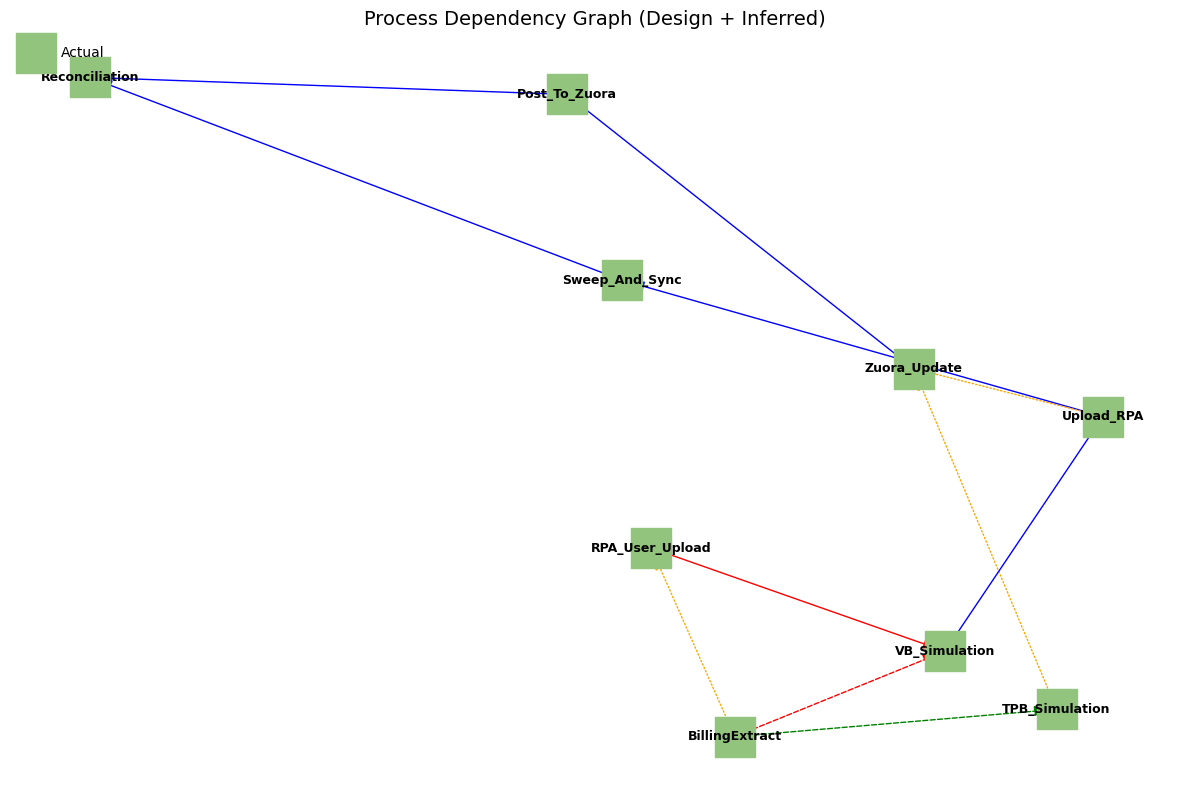

In [15]:
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.6, seed=42)
sim_nodes = [n for n,a in G.nodes(data=True) if a.get("is_sim")]
real_nodes = [n for n,a in G.nodes(data=True) if not a.get("is_sim")]
nx.draw_networkx_nodes(G,pos,nodelist=sim_nodes,node_color="#6fa8dc",
                       node_shape="o",label="Simulated",node_size=800)
nx.draw_networkx_nodes(G,pos,nodelist=real_nodes,node_color="#93c47d",
                       node_shape="s",label="Actual",node_size=800)

for (u,v,d) in G.edges(data=True):
    nx.draw_networkx_edges(G,pos,edgelist=[(u,v)],width=max(1,d["weight"]/2),
                           edge_color=d["color"],style=d["style"],
                           arrows=True,arrowsize=15)

failed_nodes = [n for n,a in G.nodes(data=True)
                if a.get("status") in ["ERROR","SYSTEM_ABORT"]]
nx.draw_networkx_nodes(G,pos,nodelist=failed_nodes,node_color="none",
                       edgecolors="red",linewidths=3,node_size=900)

nx.draw_networkx_labels(G,pos,font_size=9,font_weight="bold")
plt.legend(scatterpoints=1,loc="upper left",frameon=False)
plt.title("Process Dependency Graph (Design + Inferred)",fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


In [20]:
G1 = nx.DiGraph()
G1.add_node("BillingExtract")
G1.add_node("VB_Simulation")

G1.add_edge("BillingExtract", "VB_Simulation", color="blue", weight=3)


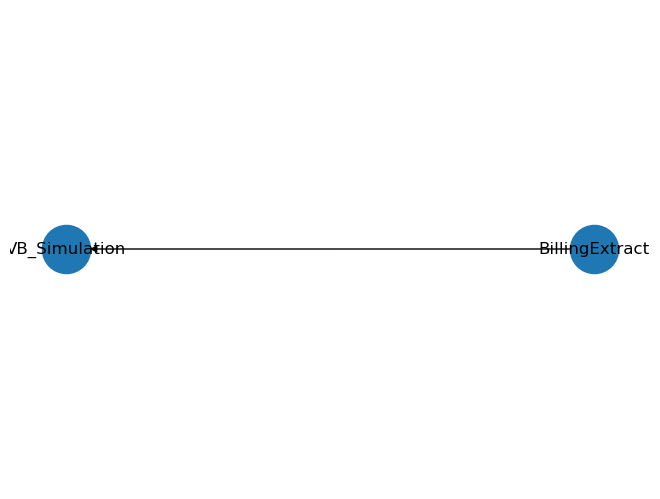

In [25]:
pos = nx.circular_layout(G1)
nx.draw(G1, pos, with_labels=True, node_size=1200)
